In [121]:
#=============================================================================
# class Cell
# usage: scr = Screen('Neurons',4,10)
#        cell = Cell(nr.at(1,2),k,g,K,P)
#        cell.show()
#=============================================================================

from carabao.screen import Screen
#import matplotlib.pyplot as plt
import torch

class Cell:
    def __init__(self,screen=None,k=None,g=None,K=None,P=None):
        self.at(screen)
        self.config(k,g,K,P)
        self.x = 0
        self.y = 0
        self.u = 0
        self.b = 0
        self.c = None
        self.q = None 
        self.x_ = None
        self.y_ = None
        self.verbose = 0    # verbose mode disabled
        self.iteration = None
        
    def config(self,k,g,K,P):
        self.k = k;
        self.g = g;  
        self.K = K;
        self.P = P;
        self.Q = P*0
        self.W = P*0
        self.Z = P*0
        self.eta = 0.5      # synaptic threshold
        self.theta = 2      # dendritic threshold
    
    def place(self,screen,ij):
        self.screen = screen
        self.ij = ij

    def at(self,screen):
        if screen != None:
            self.place(screen,screen.ij)

    def select(self,c,K):
        self.Z = 0*K
        for mu in range(0,K.size(0)):
            for nu in range(0,K.size(1)):
                self.Z[mu,nu] = c[K[mu,nu]];
        return self.Z

    def norm(self,M):    # max of column sums
        result = 0
        for j in range(0,M.size(0)):
            sumj = M[j].sum().item()
            result = result if sumj < result else sumj
        return result
            
    def iterate(self):    # update iteration count
        if self.iteration == None:
            self.iteration = 0
        else:
            self.iteration += 1

    def burst(self,c):
        self.q = []
        for k in range(0,len(self.g)):
           qk = c[self.g[k]]
           self.q.append(qk)
        b = (sum(self.q) == 0)               # burst signal
        return int(b)
   
    def input(self,u,c=None):                # update input
        self.u = u
        self.y_ = self.y
        self.y = self.u * self.x
        if c != None:
            c[self.k] = self.y
            self.c = c
        self.iterate()        
        if self.verbose > 0:
            self.log("(input)")
        return c
        
    def context(self,c):                    # update context
        self.c = c
        self.b = self.burst(c)
        self.Z = self.select(c,self.K)
        self.W = (self.P >= self.eta)
        self.Q = torch.mul(self.Z,self.W)    # synapitcs matrix
        self.x1 = self.u * (self.norm(self.Q) >= self.theta)
        if self.verbose > 0:
            self.log("(context)")
        return c

    def transition(self,c):                 # state transition
        self.x_ = self.x
        self.x = self.x1
        self.x1 = None
        c[self.k] = self.y
        self.c = c
        return c

    def clone(self,screen):
        self.screen = screen
        return self

    def plot(self,i=None,j=None):
        if i != None:
            self.place(self.screen,(i,j))
        self.screen.cell(self.ij,self.x,self.y,self.P,self.Q)
        self.screen.input(self.ij[1],self.u)
        self.screen.show

    def show(self,i=None,j=None):
        if i != None:
            self.plot(i,j)
        can = self.neurons.canvas()
        self.plot()

    def log(self,msg=None):
        msg = msg if msg != None else ""
        print("-------------------------------------------------------------")
        print("iteration: ",self.iteration,msg)
        print("   k:",self.k)
        print("   c:",self.c)
        print("   g:",self.g)
        print("   q:",self.q)
        print("   K:\n",self.K)
        print("   P:\n",self.P)
        print("   W:\n",self.W.int())
        print("   Z:\n",self.Z)
        print("   Q:\n",self.Q)
        print("   u:",self.u)
        print("   x:",self.x)
        print("   y:",self.y)
        print("   b:",self.b)
        print("   (x):",self.x_)
        print("   (y):",self.y_)
        


g: [1, 2, 3]
K:
 tensor([[1, 3, 5, 7, 9],
        [3, 4, 5, 6, 7]])
P:
 tensor([[0.1000, 0.3000, 0.5000, 0.7000, 0.0000],
        [0.0000, 0.6000, 0.4000, 0.0000, 0.0000]])


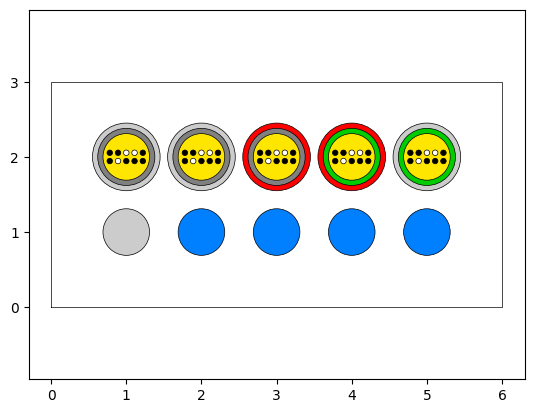

In [122]:
# Setup a cell

g = [1,2,3]                # group indices
print("g:",g)

K = torch.tensor([[1,3,5,7,9],[3,4,5,6,7]])
print("K:\n",K)

P = torch.tensor([[0.1,0.3,0.5,0.7,0],[0,0.6,0.4,0,0]])
print("P:\n",P)

    # create an inactive neuron

scr = Screen('Neurons',1,5)
cell = Cell(scr,0,g,K,P)
cell.plot()

    # cell excitation

cell.u = 1
cell.plot(0,1)

    # cell activation

cell.y = 1
cell.plot(0,2)

    # predictive state activation

cell.x = 1
cell.plot(0,3)

    # cell deactivation

cell.y = 0
cell.plot(0,4)




-------------------------------------------------------------
iteration:  None 
   k: 0
   c: None
   g: [1, 2, 3]
   q: None
   K:
 tensor([[1, 3, 5, 7, 9],
        [3, 4, 5, 6, 7]])
   P:
 tensor([[0.1000, 0.3000, 0.5000, 0.7000, 0.0000],
        [0.0000, 0.6000, 0.4000, 0.0000, 0.0000]])
   W:
 tensor([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]], dtype=torch.int32)
   Z:
 tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
   Q:
 tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
   u: 0
   x: 0
   y: 0
   b: 0
   (x): None
   (y): None


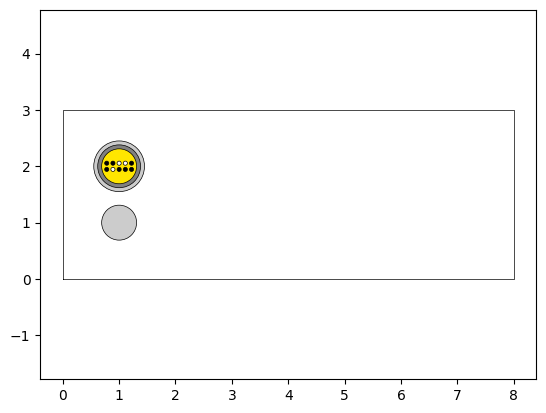

In [125]:
# step 1: create an inactive neuron

c = [0,0,0,0,1,1,1,1,0,1]    # context
scr = Screen('Neurons',1,7)
cell = Cell(scr,0,g,K,P)
cell.verbose = 1
cell.log()
cell.plot()

-------------------------------------------------------------
iteration:  0 (input)
   k: 0
   c: [0, 0, 0, 0, 1, 1, 1, 1, 0, 1]
   g: [1, 2, 3]
   q: None
   K:
 tensor([[1, 3, 5, 7, 9],
        [3, 4, 5, 6, 7]])
   P:
 tensor([[0.1000, 0.3000, 0.5000, 0.7000, 0.0000],
        [0.0000, 0.6000, 0.4000, 0.0000, 0.0000]])
   W:
 tensor([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]], dtype=torch.int32)
   Z:
 tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
   Q:
 tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
   u: 1
   x: 0
   y: 0
   b: 0
   (x): None
   (y): 0


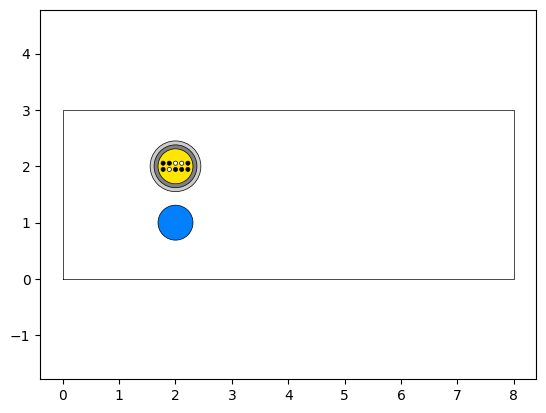

In [124]:
# step 2 / iteration 0: apply input u(0) to neuron

cell.screen = Screen('Neurons',1,7)
c = cell.input(1,c)
cell.plot(0,1)

-------------------------------------------------------------
iteration:  2 (context)
   k: 0
   c: [0, 0, 0, 0, 1, 1, 1, 1, 0, 1]
   g: [1, 2, 3]
   q: [0, 0, 0]
   K:
 tensor([[1, 3, 5, 7, 9],
        [3, 4, 5, 6, 7]])
   P:
 tensor([[0.1000, 0.3000, 0.5000, 0.7000, 0.0000],
        [0.0000, 0.6000, 0.4000, 0.0000, 0.0000]])
   W:
 tensor([[0, 0, 1, 1, 0],
        [0, 1, 0, 0, 0]], dtype=torch.int32)
   Z:
 tensor([[0, 0, 1, 1, 1],
        [0, 1, 1, 1, 1]])
   Q:
 tensor([[0, 0, 1, 1, 0],
        [0, 1, 0, 0, 0]])
   u: 1
   x: 0
   y: 0
   b: 1
   (x): None
   (y): 0


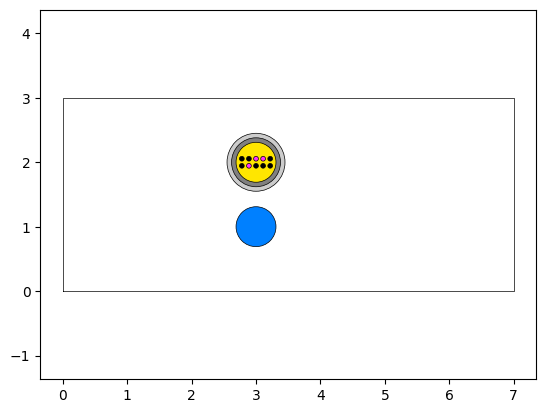

In [112]:
# step 3 / iteration 0: apply context c(0) to neuron

cell.screen = Screen('Neurons',1,7)
c = cell.context(c)
cell.plot(0,2)

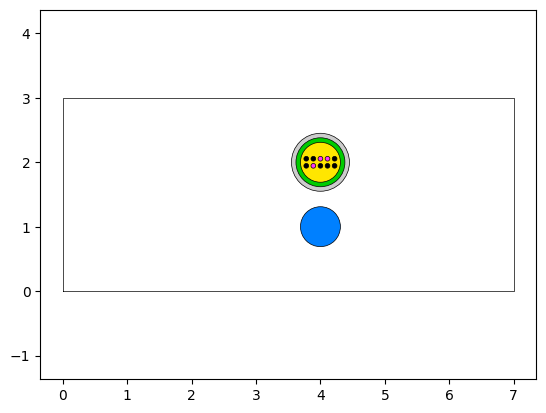

In [113]:
# step 4 / iteration 0: perform state transition

cell.screen = Screen('Neurons',1,7)
c = cell.transition(c)
cell.plot(0,3)

-------------------------------------------------------------
iteration:  3 (input)
   k: 0
   c: [1, 0, 0, 0, 1, 1, 1, 1, 0, 1]
   g: [1, 2, 3]
   q: [0, 0, 0]
   K:
 tensor([[1, 3, 5, 7, 9],
        [3, 4, 5, 6, 7]])
   P:
 tensor([[0.1000, 0.3000, 0.5000, 0.7000, 0.0000],
        [0.0000, 0.6000, 0.4000, 0.0000, 0.0000]])
   W:
 tensor([[0, 0, 1, 1, 0],
        [0, 1, 0, 0, 0]], dtype=torch.int32)
   Z:
 tensor([[0, 0, 1, 1, 1],
        [0, 1, 1, 1, 1]])
   Q:
 tensor([[0, 0, 1, 1, 0],
        [0, 1, 0, 0, 0]])
   u: 1
   x: 1
   y: 1
   b: 1
   (x): 0
   (y): 0


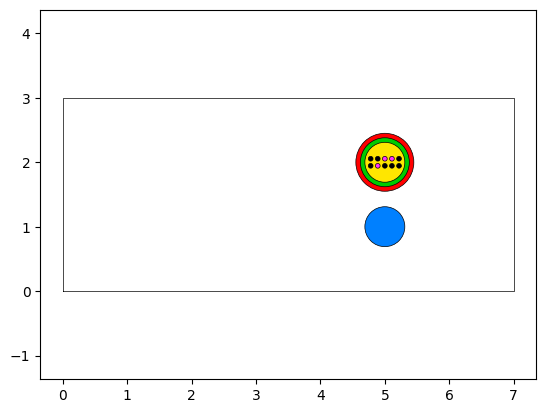

In [114]:
# step 5 / iteration 1: apply input u(0) to neuron

cell.screen = Screen('Neurons',1,7)
c = cell.input(1,c)
cell.plot(0,4)

-------------------------------------------------------------
iteration:  3 (context)
   k: 0
   c: [1, 0, 0, 0, 1, 1, 1, 1, 0, 1]
   g: [1, 2, 3]
   q: [0, 0, 0]
   K:
 tensor([[1, 3, 5, 7, 9],
        [3, 4, 5, 6, 7]])
   P:
 tensor([[0.1000, 0.3000, 0.5000, 0.7000, 0.0000],
        [0.0000, 0.6000, 0.4000, 0.0000, 0.0000]])
   W:
 tensor([[0, 0, 1, 1, 0],
        [0, 1, 0, 0, 0]], dtype=torch.int32)
   Z:
 tensor([[0, 0, 1, 1, 1],
        [0, 1, 1, 1, 1]])
   Q:
 tensor([[0, 0, 1, 1, 0],
        [0, 1, 0, 0, 0]])
   u: 1
   x: 1
   y: 1
   b: 1
   (x): 0
   (y): 0


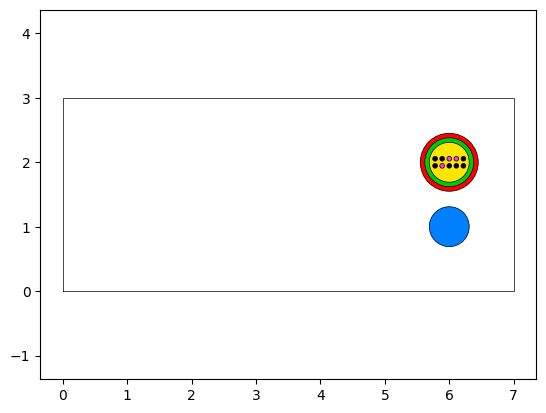

In [115]:
# step 6 / iteration 1: apply context c(0) to neuron

cell.screen = Screen('Neurons',1,7)
cell.context(c)
cell.plot(0,5)

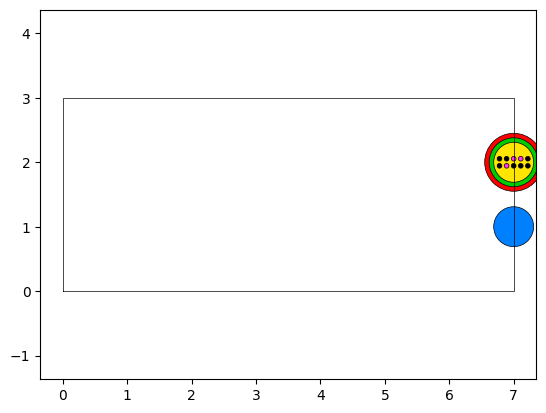

In [116]:
# step 7 / iteration 1: perform state transition

cell.screen = Screen('Neurons',1,7)
c = cell.transition(c)
cell.plot(0,6)

-------------------------------------------------------------
iteration:  0 (input)
   k: 0
   c: [0, 0, 0, 0, 1, 1, 1, 1, 0, 1]
   g: [1, 2, 3]
   q: None
   K:
 tensor([[1, 3, 5, 7, 9],
        [3, 4, 5, 6, 7]])
   P:
 tensor([[0.1000, 0.3000, 0.5000, 0.7000, 0.0000],
        [0.0000, 0.6000, 0.4000, 0.0000, 0.0000]])
   W:
 tensor([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]], dtype=torch.int32)
   Z:
 tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
   Q:
 tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
   u: 1
   x: 0
   y: 0
   b: 0
   (x): None
   (y): 0
-------------------------------------------------------------
iteration:  0 (context)
   k: 0
   c: [0, 0, 0, 0, 1, 1, 1, 1, 0, 1]
   g: [1, 2, 3]
   q: [0, 0, 0]
   K:
 tensor([[1, 3, 5, 7, 9],
        [3, 4, 5, 6, 7]])
   P:
 tensor([[0.1000, 0.3000, 0.5000, 0.7000, 0.0000],
        [0.0000, 0.6000, 0.4000, 0.0000, 0.0000]])
   W:
 tensor([[0, 0, 1, 1, 0],
        [0, 1, 0, 0, 0]], dtype=torch.int32)
   Z

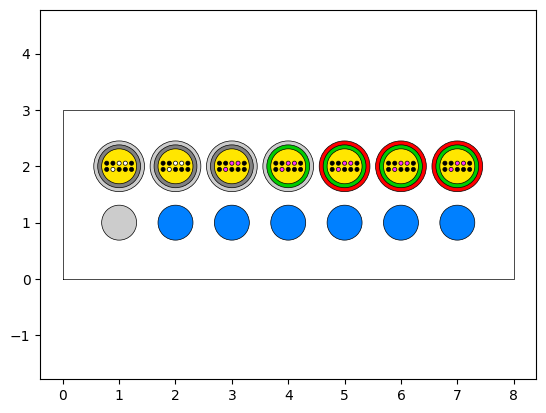

In [117]:
# all together now

    # step 1: create an inactive neuron

scr = Screen('Neurons',1,7)
c = [0,0,0,0,1,1,1,1,0,1]    # context

cell = Cell(scr,0,g,K,P)
cell.verbose = 1
cell.plot()

    # step 2 / iteration 0: apply input u(0) to neuron

c = cell.input(1,c)
cell.plot(0,1)

    # step 3 / iteration 0: apply context c(0) to neuron

c = cell.context(c)
cell.plot(0,2)

    # step 4 / iteration 0: perform state transition

c = cell.transition(c)
cell.plot(0,3)

    # step 5 / iteration 1: apply input u(0) to neuron

c = cell.input(1,c)
cell.plot(0,4)

    # step 6 / iteration 1: apply context c(0) to neuron

cell.context(c)
cell.plot(0,5)

    # step 7 / iteration 1: perform state transition

c = cell.transition(c)
cell.plot(0,6)

